# Trabajo practico Nº2
### Mineria de datos - TUIA
### 08/11/2024
#### Integrantes:
Bravi Eugenio B-6600/1

Nemeth Ulises N-1249/1

# Librerias

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split

# Carga de datos

In [4]:
df_companies = pd.read_csv('./1000_Companies.csv')
df_companies.head()

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [5]:
df_pokemon = pd.read_csv('./PokemonDBCart.csv')
df_pokemon.head()

,Nombre,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon
0,Bulbasaur,49,49,45,45,65,65,hierba
1,Ivysaur,62,63,60,60,80,80,hierba
2,Venusaur,100,123,80,80,122,120,hierba
3,Charmander,52,43,65,39,60,50,fuego
4,Charmeleon,64,58,80,58,80,65,fuego


# 1. Analisis de datos

In [6]:
df_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


In [7]:
df_companies.isna().sum()

RyD_Spend         0
Administration    0
MarketingSpend    0
State             0
Profit            0
dtype: int64

In [11]:
x_train_comp, x_test_comp, y_train_comp, y_test_comp = train_test_split(df_companies.drop('Profit', axis=1), df_companies['Profit'], test_size=0.2, random_state=42)

In [12]:
x_train_comp.describe()

,RyD_Spend,Administration,MarketingSpend
count,800.000000,800.000000,800.000000
mean,81975.291150,122887.896835,226969.821069
std,46707.482003,11574.679339,92039.930034
min,0.000000,51283.140000,0.000000
25%,43084.500000,116654.899500,150969.584600
50%,81054.500000,122746.690400,228190.695800
75%,123806.750000,129060.069850,307664.501425
max,165349.200000,270939.860000,471784.100000


array([[<Axes: title={'center': 'RyD_Spend'}>,
        <Axes: title={'center': 'Administration'}>],
       [<Axes: title={'center': 'MarketingSpend'}>, <Axes: >]],
      dtype=object)

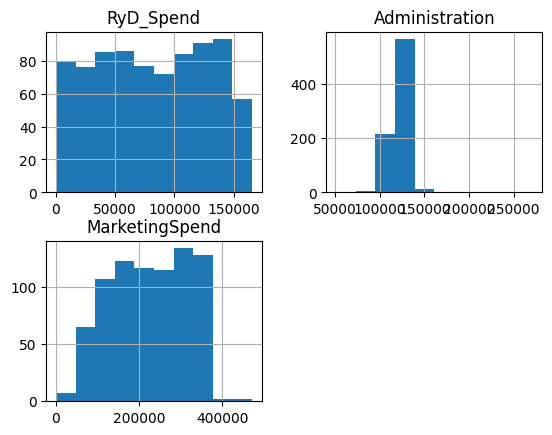

In [15]:
x_train_comp.hist()